In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


df = pd.read_csv('data/joined.csv', index_col = 'SchoolId')
df = df.drop(df[df['Coeducational'] != 'Yes'].index)
df = df.drop(df[df['Institution Type'] == 'Private for-profit'].index)
df = df.select_dtypes('float')
mask = df.isna().sum() / len(df) > 0.7
df = df.drop(columns = df.columns[mask])
df = df.fillna(df.mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1660 entries, 659 to 3378
Columns: 137 entries, 2016 Graduates Who Took Out Loans to Yield Rate (women)
dtypes: float64(137)
memory usage: 1.7 MB


In [2]:
y = (df['Yield Rate (women)'] - df['Yield Rate (men)']) / df['Yield Rate (men)']

drop_cols = ['Yield Rate (all)', 'Yield Rate (men)', 'Yield Rate (women)',
             'Freshmen Enrolled (all)', 'Freshmen Enrolled (men)', 'Freshmen Enrolled (women)']

X = df.drop(columns = drop_cols)

In [3]:
reg = Ridge(normalize = True)

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
reg_scores = []
reg_scores_std = []

for alpha in alpha_space:
    reg.alpha = alpha
    cv_scores = cross_val_score(reg, X, y, cv = 10)
    reg_scores.append(np.mean(cv_scores))
    reg_scores_std.append(np.std(cv_scores))

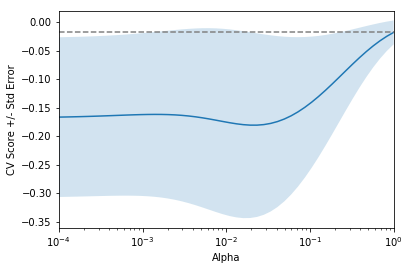

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(alpha_space, reg_scores)

std_error = reg_scores_std / np.sqrt(10)

ax.fill_between(alpha_space, reg_scores + std_error, reg_scores - std_error, alpha=0.2)
ax.set_ylabel('CV Score +/- Std Error')
ax.set_xlabel('Alpha')
ax.axhline(np.max(reg_scores), linestyle='--', color='.5')
ax.set_xlim([alpha_space[0], alpha_space[-1]])
ax.set_xscale('log')
plt.show()

In [5]:
ranks = pd.read_csv('data/joined.csv', index_col = 'SchoolId', usecols = ['SchoolId','Rank Type'])
df = df.join(ranks)

In [6]:
y = df['Rank Type']
X = df.drop(columns='Rank Type')

def run_classifier(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    knn = KNeighborsClassifier(n_neighbors = 5)

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(classification_report(y_test, y_pred))
    
run_classifier(X, y)

                                precision    recall  f1-score   support

National Liberal Arts Colleges       0.38      0.53      0.44        59
         National Universities       0.51      0.64      0.57        67
     Regional Colleges Midwest       0.08      0.11      0.09        18
       Regional Colleges North       0.00      0.00      0.00         8
       Regional Colleges South       0.00      0.00      0.00        20
        Regional Colleges West       0.00      0.00      0.00         9
 Regional Universities Midwest       0.19      0.17      0.18        36
   Regional Universities North       0.11      0.07      0.08        46
   Regional Universities South       0.25      0.14      0.18        35
    Regional Universities West       0.11      0.04      0.06        27
               Unranked School       0.46      0.59      0.52        90

                   avg / total       0.30      0.35      0.31       415



In [7]:
y = y.replace(r'Regional.*', 'Regional', regex=True)
y = y.replace(r'National.*', 'National', regex=True)

run_classifier(X, y)

                 precision    recall  f1-score   support

       National       0.63      0.59      0.61       122
       Regional       0.61      0.74      0.67       192
Unranked School       0.60      0.42      0.49       101

    avg / total       0.62      0.62      0.61       415

